In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [3]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

In [4]:
data = pd.read_csv("./census.csv", sep=',', decimal='.')
data.tail()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
45217,33,Private,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
45218,39,Private,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K
45221,35,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K


In [5]:
data.shape

(45222, 14)

### Análisis exploratorio


In [6]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [7]:
data['income'] = np.where(data['income'] == '<=50K',0,1)

In [8]:
data.dtypes

age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income               int32
dtype: object

Encontramos 8 variables categóricas

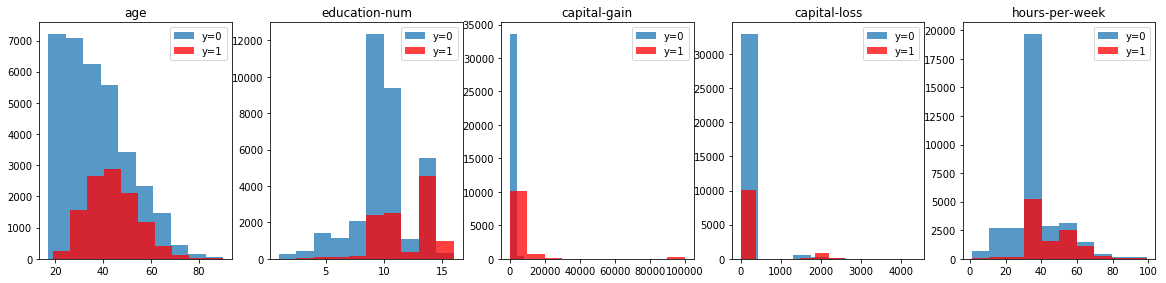

In [9]:
# Pintamos histogramas para cada variable no categórica
plt.figure(figsize=(20,20))

idx_0 =  data['income'] == 0
idx_1 =  data['income'] == 1

columns_to_drop = ['income', 'workclass','education_level','marital-status','occupation','relationship','race','sex','native-country']

# your code here
for i,feature in enumerate(data.columns.drop(columns_to_drop)):
    plt.subplot(4,5,i+1)   
    plt.hist(data.loc[idx_0,feature],normed=0, alpha=0.75,label='y=0')
    plt.hist(data.loc[idx_1,feature],normed=0, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

Parece que encontramos cierto desbalanceo entre las muestras, vamos a ver si es así

In [10]:
#Ratio de desbalanceo, divido entre el total de filas
data['income'].value_counts()/data.shape[0]

0    0.752156
1    0.247844
Name: income, dtype: float64

Efectivamente, encontramos un 75% de las muestras que son de clase ingresos menores de 50K y un 25% de ingresos mayores que 50K

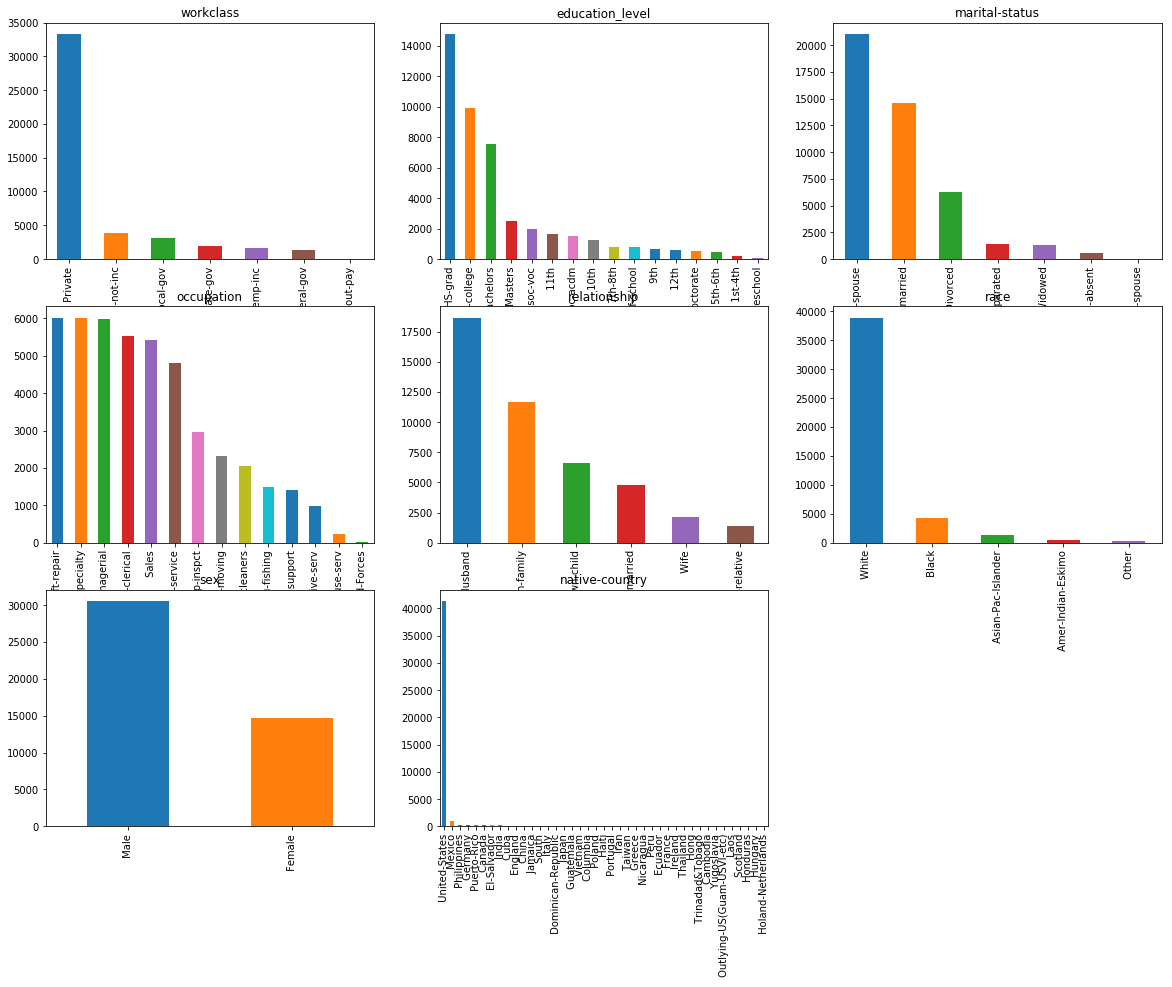

In [11]:
#Pintamos gráficos de barras para las variables no categóricas
plt.figure(figsize=(20,20))

idx_0 =  data['income'] == 0
idx_1 =  data['income'] == 1

columns_to_drop = ['income', 'age','education-num','capital-gain','capital-loss','hours-per-week']

# your code here
for i,feature in enumerate(data.columns.drop(columns_to_drop)):
    plt.subplot(4,3,i+1)   
    plot = data[feature].value_counts().plot(kind='bar',
                                            title=feature)
plt.show()

A la vista de la representación voy a hacer un descarte de características basándome por un lado en mi intuición (voy a eliminar marital-status y relationship, ya que a priori no deberían influir en el número de ingresos) y por otro lado en la distribución de los datos (elimino race y native-country, ya que predominan valores de una sóla clase). Estudiaré esta primera aproximación y si el modelo es deficiente intentaría mejorarlo añadiendo alguna de estas caracterísiticas que han quedado fuera.

### Preprocesamiento

Borro las características mencionadas y codifico las variables categóricas

In [12]:
from sklearn.preprocessing import LabelEncoder

columns_to_drop = ['marital-status','relationship','race','native-country']
data = data.drop(columns_to_drop, axis=1)

le = LabelEncoder()

data['workclass'] = le.fit_transform(data['workclass'])
data['education_level'] = le.fit_transform(data['education_level'])
data['occupation'] = le.fit_transform(data['occupation'])
data['sex'] = le.fit_transform(data['sex'])
print('N,D:',data.shape)

data.head(10)


N,D: (45222, 10)


,age,workclass,education_level,education-num,occupation,sex,capital-gain,capital-loss,hours-per-week,income
0,39,5,9,13.0,0,1,2174.0,0.0,40.0,0
1,50,4,9,13.0,3,1,0.0,0.0,13.0,0
2,38,2,11,9.0,5,1,0.0,0.0,40.0,0
3,53,2,1,7.0,5,1,0.0,0.0,40.0,0
4,28,2,9,13.0,9,0,0.0,0.0,40.0,0
5,37,2,12,14.0,3,0,0.0,0.0,40.0,0
6,49,2,6,5.0,7,0,0.0,0.0,16.0,0
7,52,4,11,9.0,3,1,0.0,0.0,45.0,1
8,31,2,12,14.0,9,0,14084.0,0.0,50.0,1
9,42,2,9,13.0,3,1,5178.0,0.0,40.0,1


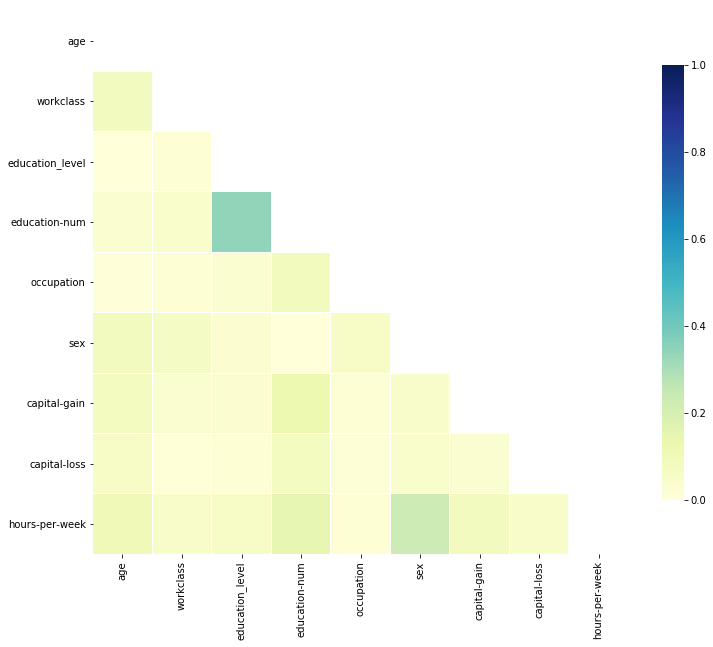

In [13]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['income'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

A la vista de los resultados parece que no haya mucha correlación entre las variables que he dejado, algo más entre education_level y education-num, algo que por otro lado tiene mucho sentido, ya que el número de años de educación completados está relacionado con el nivel educativo. En una primera pasada probé a borrar esta variable pero no obtuve buenas prestaciones del modelo, así que la volví a incluir y me salió algo mejor. No incluyo estas iteraciones en el Notebook para que quede más claro el proceso.

### Selección del modelo

Voy a optar por un método incremental. Primero construiré un modelo sencillo de regresión logística, para después aplicar distintos algoritmos más complejos para comprobar si se mejoran las prestaciones del modelo inicial.

## Primera aproximación: Regresión logística

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# preparamos los datos

features = data.columns.drop(['income'])

X = data[features].as_matrix()
y = data['income'].as_matrix()


# PASO 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=0)

scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))


Datos train:  (33916, 9)
Datos test:   (11306, 9)
Propocion train:0.248
Propocion test: 0.248


**NOTA:** Estratifico las muestras para obtener la misma proporción en train que en test.  
Voy a hacer un primer estudio de las métricas que ofrece el modelo de regresión logística

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1).fit(Xs_train, y_train)

print('Logistic Regression Train: ', lr.score(Xs_train,y_train))
print('Logistic Regression Test: ', lr.score(Xs_test,y_test))

Logistic Regression Train:  0.8184042929590754
Logistic Regression Test:  0.8180612064390589


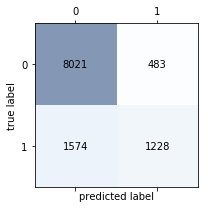

ACC:  0.8180612064390589
SEN:  0.4382583868665239
ESP:  0.9432031984948259
PPV:  0.7177089421391
FSC:  0.5442056281852427


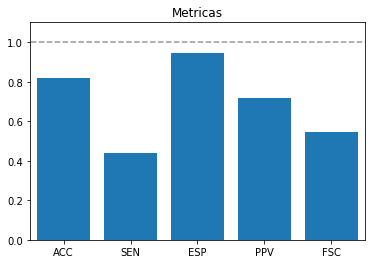

In [16]:
from sklearn.metrics import confusion_matrix

y_pred_test = lr.predict(Xs_test)


confmat_test = confusion_matrix(y_test,y_pred_test)
plot_confusion_matrix(confmat_test)

calcula_metricas(confmat_test)


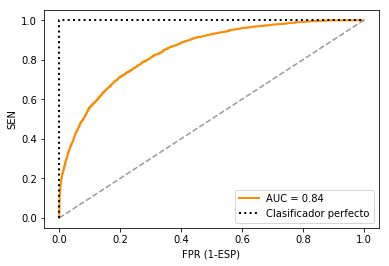

In [17]:
from sklearn.metrics import roc_curve, auc

y_prob = lr.predict_proba(Xs_test)[:,1]
ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Este modelo es mejorable, vamos a intentarlo ajustando el valor de C (Regularización)

best mean cross-validation score: 0.611
best parameters: {'C': 0.1}


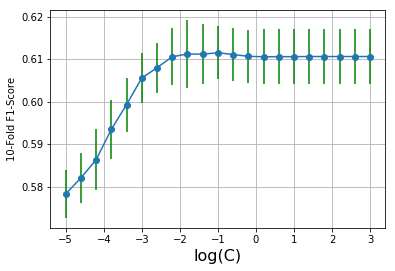

In [18]:
from sklearn.model_selection import GridSearchCV

vectorC = np.logspace(-5,3,21)
param_grid = {'C': vectorC }

grid = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced'),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 10)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold F1-Score')
plt.grid()
plt.show()

Vamos a entrenar el modelo usando el valor óptimo de C

Logistic Regression Train:  0.764359004599599
Logistic Regression Test:  0.7669379090748275


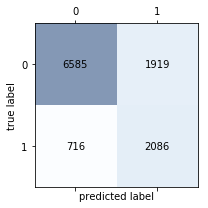

ACC:  0.7669379090748275
SEN:  0.7444682369735903
ESP:  0.7743414863593603
PPV:  0.5208489388264669
FSC:  0.6128984868517702


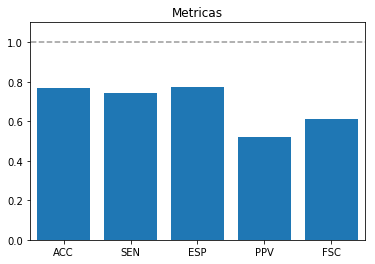

In [19]:
Copt = grid.best_params_['C']

lr = LogisticRegression(random_state=0, C = Copt, class_weight='balanced').fit(Xs_train,y_train)
y_pred = lr.predict(Xs_test)

print('Logistic Regression Train: ', lr.score(Xs_train,y_train))
print('Logistic Regression Test: ', lr.score(Xs_test,y_test))

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

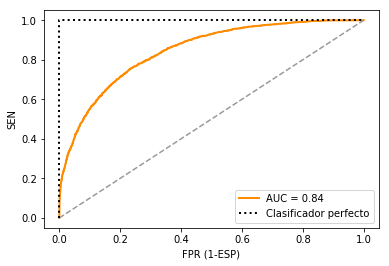

In [20]:
from sklearn.metrics import roc_curve, auc

y_prob = lr.predict_proba(Xs_test)[:,1]
ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

**Segunda Iteración:** No hemos mejorado. Voy a probar dejando las variables que en un principio dejé fuera.

In [21]:
data = pd.read_csv("./census.csv", sep=',', decimal='.')
data['income'] = np.where(data['income'] == '<=50K',0,1)

le = LabelEncoder()

data['marital-status'] = le.fit_transform(data['marital-status'])
data['relationship'] = le.fit_transform(data['relationship'])
data['race'] = le.fit_transform(data['race'])
data['native-country'] = le.fit_transform(data['native-country'])
data['workclass'] = le.fit_transform(data['workclass'])
data['education_level'] = le.fit_transform(data['education_level'])
data['occupation'] = le.fit_transform(data['occupation'])
data['sex'] = le.fit_transform(data['sex'])
print('N,D:',data.shape)

data.head(10)

N,D: (45222, 14)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,5,9,13.0,4,0,1,4,1,2174.0,0.0,40.0,38,0
1,50,4,9,13.0,2,3,0,4,1,0.0,0.0,13.0,38,0
2,38,2,11,9.0,0,5,1,4,1,0.0,0.0,40.0,38,0
3,53,2,1,7.0,2,5,0,2,1,0.0,0.0,40.0,38,0
4,28,2,9,13.0,2,9,5,2,0,0.0,0.0,40.0,4,0
5,37,2,12,14.0,2,3,5,4,0,0.0,0.0,40.0,38,0
6,49,2,6,5.0,3,7,1,2,0,0.0,0.0,16.0,22,0
7,52,4,11,9.0,2,3,0,4,1,0.0,0.0,45.0,38,1
8,31,2,12,14.0,4,9,1,4,0,14084.0,0.0,50.0,38,1
9,42,2,9,13.0,2,3,0,4,1,5178.0,0.0,40.0,38,1


In [22]:
# preparamos los datos
features = data.columns.drop(['income'])

X = data[features].as_matrix()
y = data['income'].as_matrix()


# PASO 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=0)

scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))


Datos train:  (33916, 13)
Datos test:   (11306, 13)
Propocion train:0.248
Propocion test: 0.248


best mean cross-validation score: 0.618
best parameters: {'C': 0.1}


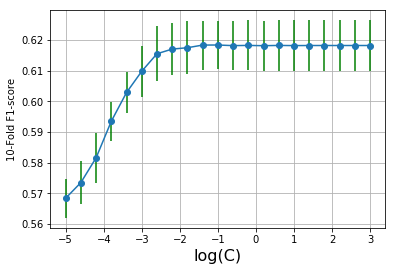

In [23]:
#Elegimos el parámetro de regularización
vectorC = np.logspace(-5,3,21)
param_grid = {'C': vectorC }

grid = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced'),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 10)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold F1-score')
plt.grid()
plt.show()

Logistic Regression Train:  0.7665113810590871
Logistic Regression Test:  0.7676454979656819


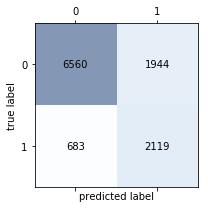

ACC:  0.7676454979656819
SEN:  0.7562455389007852
ESP:  0.7714016933207902
PPV:  0.5215358109771105
FSC:  0.617334304442826


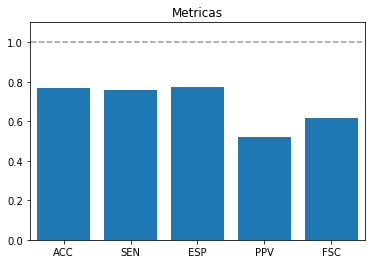

In [24]:
Copt = grid.best_params_['C']
lr = LogisticRegression(random_state=0, C=Copt,class_weight='balanced').fit(Xs_train, y_train)
y_pred_test = lr.predict(Xs_test)

print('Logistic Regression Train: ', lr.score(Xs_train,y_train))
print('Logistic Regression Test: ', lr.score(Xs_test,y_test))

confmat_test = confusion_matrix(y_test,y_pred_test)
plot_confusion_matrix(confmat_test)

calcula_metricas(confmat_test)

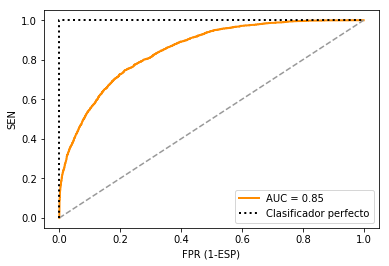

In [25]:
y_prob = lr.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Cogiendo todas las variables hemos mejorado un poco, pero muy poco y el modelo ahora es más complejo

## Segunda aproximación: Árboles de decisión
A partir de ahora seguiré con el conjunto de variables completo

best mean cross-validation score: 0.669
best parameters: {'max_depth': 10}


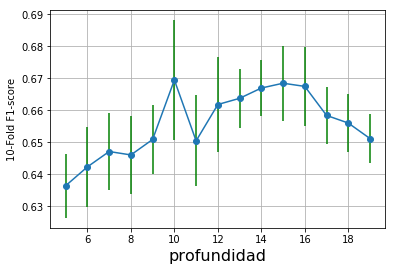

In [26]:
from sklearn.tree import DecisionTreeClassifier
maxDepth = range(5,20)
param_grid = {'max_depth': maxDepth }


grid = GridSearchCV(DecisionTreeClassifier(random_state=0),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 10)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(maxDepth,scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('profundidad',fontsize=16)
plt.ylabel('10-Fold F1-score')
plt.grid()
plt.show()


Decision Tree Train:  0.8631914140818493
Decision Tree Test:  0.8499911551388644


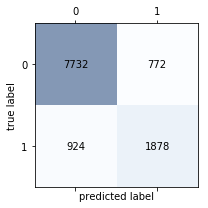

ACC:  0.8499911551388644
SEN:  0.6702355460385439
ESP:  0.9092191909689558
PPV:  0.7086792452830188
FSC:  0.6889214966984593


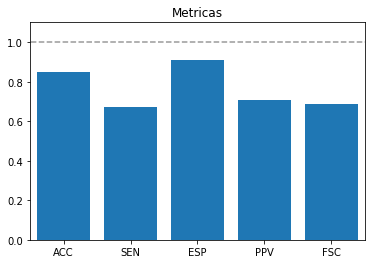

In [27]:
depthOpt = grid.best_params_['max_depth']

tree = DecisionTreeClassifier(random_state=0, max_depth=depthOpt).fit(Xs_train,y_train)
y_pred = tree.predict(Xs_test)

print('Decision Tree Train: ', tree.score(Xs_train,y_train))
print('Decision Tree Test: ', tree.score(Xs_test,y_test))

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

Tenemos mejores valores para las métricas en este caso. Sobre todo hemos mejorado bastante la precisión (PPV) y el F1Score, que es el compromiso entre precisión y sensibilidad, aunque hemos bajado un poco en sensibilidad. Voy a ver qué tal la curva ROC.

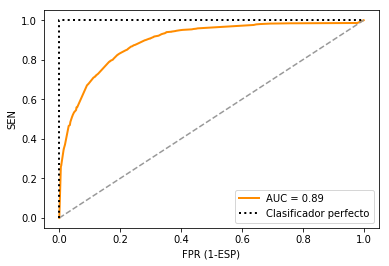

In [28]:
y_prob = tree.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

La curva ROC también mejora, tenemos un AUC de 0.89 que es mejor

## Tercera aproximación: Random forest

best mean cross-validation score: 0.689
best parameters: {'max_depth': 18}


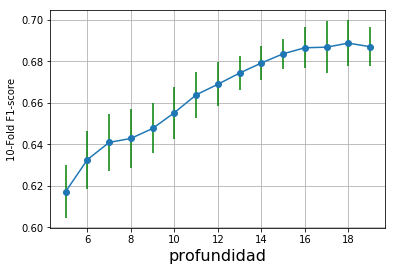

In [30]:
from sklearn.ensemble import RandomForestClassifier

# grid search
maxDepth   = range(5,20)
param_grid = {'max_depth': maxDepth}
grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt'),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 10,
                    n_jobs=3)              
grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(maxDepth,scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('profundidad',fontsize=16)
plt.ylabel('10-Fold F1-score')
plt.grid()
plt.show()

Random Forest Train:  0.9204800094350749
Random Forest Test:  0.8605165398903237


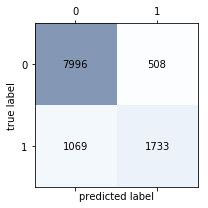

ACC:  0.8605165398903237
SEN:  0.6184867951463241
ESP:  0.9402634054562559
PPV:  0.7733154841588576
FSC:  0.6872893119175094


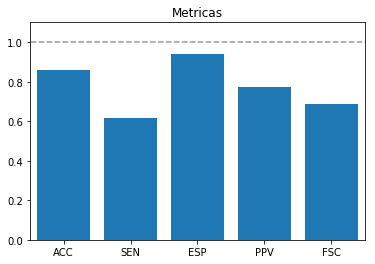

In [31]:
depthOpt = grid.best_params_['max_depth']

randomForest = RandomForestClassifier(random_state=0, n_estimators=200, max_depth=depthOpt, max_features='sqrt').fit(Xs_train,y_train)
y_pred = randomForest.predict(Xs_test)

print('Random Forest Train: ', randomForest.score(Xs_train,y_train))
print('Random Forest Test: ', randomForest.score(Xs_test,y_test))

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

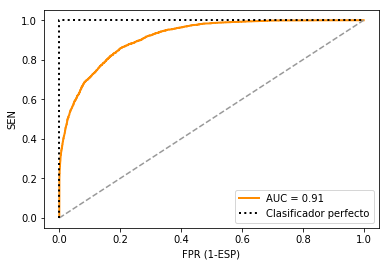

In [32]:
y_prob = randomForest.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Este modelo mejora al anterior, dando una AUC de 0.91, sin embargo este resultado no me convence demasiado, ya que para árboles de decisión obtuve una profundidad óptima de 10 y ahora son 18, que me resulta un valor muy elevado para ser un Random Forest. Observo que para una profundidad de 15 puedo tener un modelo más sencillo y con menos desviación típica, voy a probar con esta profundidad.

Random Forest Train:  0.8957129378464441
Random Forest Test:  0.8623739607288166


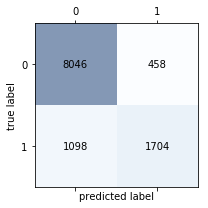

ACC:  0.8623739607288166
SEN:  0.6081370449678801
ESP:  0.9461429915333961
PPV:  0.788159111933395
FSC:  0.686543110394843


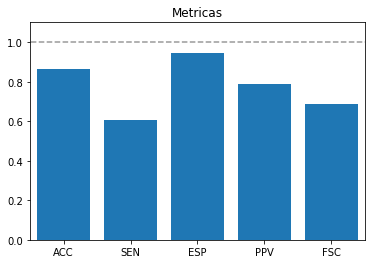

In [33]:
depthElegido = 15

randomForest = RandomForestClassifier(random_state=0, n_estimators=200, max_depth=depthElegido, max_features='sqrt').fit(Xs_train,y_train)
y_pred = randomForest.predict(Xs_test)

print('Random Forest Train: ', randomForest.score(Xs_train,y_train))
print('Random Forest Test: ', randomForest.score(Xs_test,y_test))

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

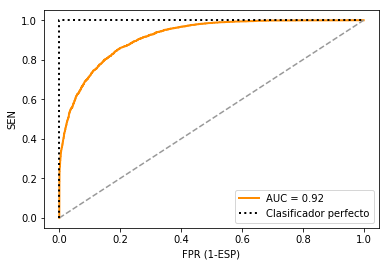

In [34]:
y_prob = randomForest.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Hemos mejorado el AUC en un punto con un modelo de menos profundidad, así que me quedaría con este último resultado. Además obtenemos mejores prestaciones, ya que para random forest con profundidad 18 teníamos:
```
Random Forest Train:  0.9204800094350749
Random Forest Test:  0.8605165398903237
```
Observamos que parece que hay cierto overfitting mientras que para random forest con profundidad 15 tenemos:
```
Random Forest Train:  0.8957129378464441
Random Forest Test:  0.8623739607288166
```
Que son mejores prestaciones.


## Cuarta aproximación: Boosted Trees

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

n_iterations = [25,50,75,100,125,150,175,200,300]
learning_rate = [0.5, 0.1, 0.05, 0.1]
# mantenemos max_depth estático: max_depth=2

param_grid = {'n_estimators': n_iterations,'learning_rate':learning_rate }
grid = GridSearchCV(GradientBoostingClassifier(random_state=0, max_depth=2), param_grid=param_grid, cv = 5, n_jobs=2)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.870
best parameters: {'learning_rate': 0.5, 'n_estimators': 300}


Boosted Trees Train:  0.8772260879820734
Boosted Trees Test:  0.872014859366708


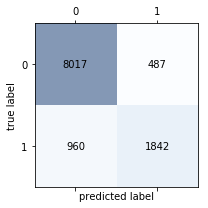

ACC:  0.872014859366708
SEN:  0.6573875802997858
ESP:  0.9427328316086547
PPV:  0.7908973808501503
FSC:  0.7179886961605924


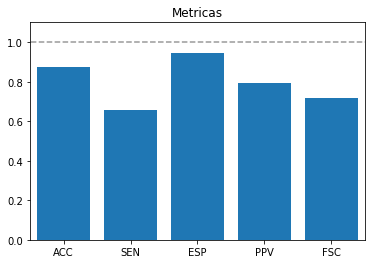

In [36]:
learningRateOpt = grid.best_params_['learning_rate']
nEstimatorsOpt = grid.best_params_['n_estimators']
bt = GradientBoostingClassifier(random_state=0, max_depth=2,learning_rate=learningRateOpt, n_estimators= nEstimatorsOpt).fit(Xs_train,y_train)
y_pred = bt.predict(Xs_test)

print('Boosted Trees Train: ', bt.score(Xs_train,y_train))
print('Boosted Trees Test: ', bt.score(Xs_test,y_test))

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

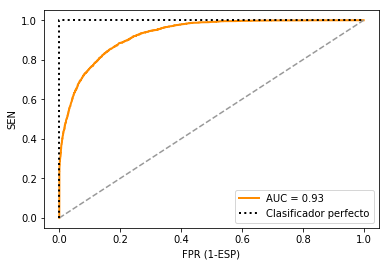

In [37]:
y_prob = bt.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Mejoramos ligeramente la superficie por debajo de la curva ROC y las prestaciones en test son un pelín mejores;
```
Random Forest Train:  0.8957129378464441
Random Forest Test:  0.8623739607288166

Boosted Trees Train:  0.8772260879820734
Boosted Trees Test:  0.872014859366708
```

Podríamos seguir con KNN y SVM

## Quinta aproximación: Vecinos más próximos 

best mean cross-validation score: 0.834
best parameters: {'n_neighbors': 14}


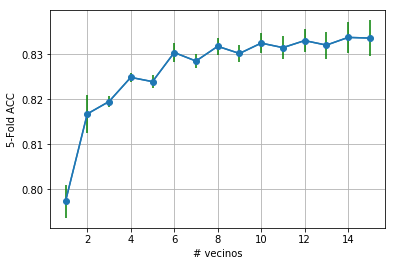

acc (test): 0.77


In [38]:
from sklearn.neighbors import KNeighborsClassifier

nVecinos = np.arange(1, 16, 1)
param_grid = {'n_neighbors':  nVecinos}
grid = GridSearchCV(KNeighborsClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 5)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid.cv_results_['std_test_score'])
plt.plot(nVecinos,scores,'-o')
plt.errorbar(nVecinos, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('# vecinos')
plt.ylabel('5-Fold ACC')
plt.grid()
plt.show()

print("acc (test): {:.2f}".format(grid.score(X_test, y_test)))

Knn Train:  0.8542280929354876
Knn Test:  0.8342473023173537


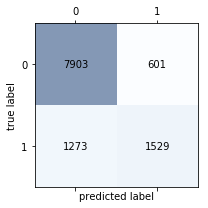

ACC:  0.8342473023173537
SEN:  0.5456816559600286
ESP:  0.9293273753527752
PPV:  0.7178403755868544
FSC:  0.6200324412003245


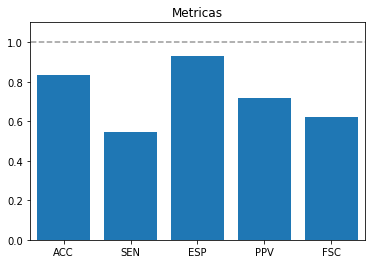

In [39]:
NVecinosOpt = grid.best_params_['n_neighbors']
knn = KNeighborsClassifier(n_neighbors=NVecinosOpt)
knn.fit(Xs_train,y_train)
y_pred = knn.predict(Xs_test)

print('Knn Train: ', knn.score(Xs_train,y_train))
print('Knn Test: ', knn.score(Xs_test,y_test))

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

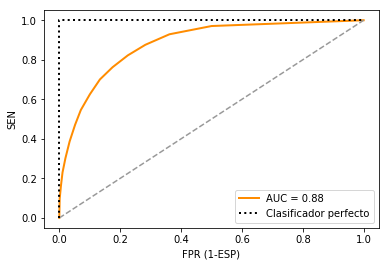

In [40]:
y_prob = knn.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Este modelo me da peores prestaciones que los anteriores. Se me ocurre mirando el gráfico probar con 10 vecinos en lugar del valor óptimo de GridSearchCV.

Knn Train:  0.859240476471282
Knn Test:  0.8307978064744383


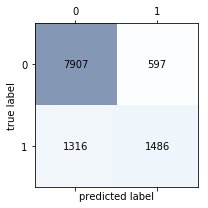

ACC:  0.8307978064744383
SEN:  0.5303354746609564
ESP:  0.9297977422389464
PPV:  0.7133941430628901
FSC:  0.6083930399181168


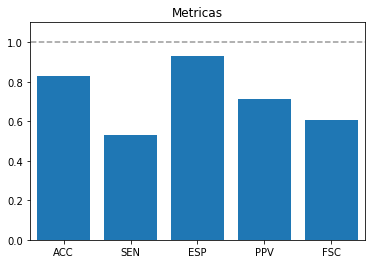

In [41]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(Xs_train,y_train)
y_pred = knn.predict(Xs_test)

print('Knn Train: ', knn.score(Xs_train,y_train))
print('Knn Test: ', knn.score(Xs_test,y_test))

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

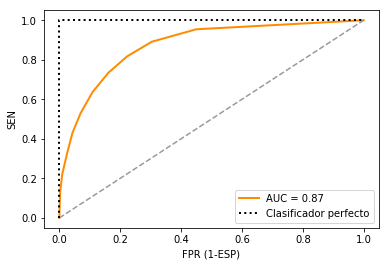

In [42]:
y_prob = knn.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Ofrece peores prestaciones que con 14 vecinos, pero tampoco varía demasiado, y es más sencillo. De todos los modelos estudiados, el que mejores prestaciones me ha dado ha sido Boosted Trees, pero tendría que valorar tener un modelo más complejo y que tarda más en entrenarse versus ganancia en prestaciones. Dependerá del caso de uso que estoy haciendo.